# Download data

Download ephys data from the original paper from EBRAINS: https://search.kg.ebrains.eu/instances/a25f722e-f9b1-4f32-80bc-37206c2d1536

Navigate to `data/calcium/60584/2019-01-29/MUnit0/` (session #7), open the suite2p folder and click "Download folder" on the right. Move the folder to a new `data` directory in the base directory of this repo.


# Import libraries

In [1]:
import os
import re

import numpy as np
import matplotlib.pyplot as plt
import pynapple as nap
import pandas as pd
import seaborn as sns

from natsort import natsorted
from datetime import datetime
from pathlib import Path
from scipy.stats import binned_statistic, zscore
from scipy.signal import correlate

nap.nap_config.set_backend("jax")

# Preprocess imaging data

## Load Suite2P data

In [2]:
# I think for our simple replication we can just load the spks.npy file, but for full dataset information use the s2p loader
use_s2p_loader = False

if use_s2p_loader:
    # initialize s2p loader
    from suite2py import Suite2PLoader
    s2p_path = "data/calcium-60584-2019-01-29-MUnit_0-suite2p/plane0"
    location = Path(s2p_path)
    suite2py_files = {
    	"ops": location / "ops.npy",
    	"Fneu": location / "Fneu.npy",
    	"Fneu_chan2": location / "Fneu_chan2.npy",
    	"F": location / "F.npy",
    	"F_chan2": location / "F_chan2.npy",
    	"iscell": location / "iscell.npy",
    	"spks": location / "spks.npy",
    	"stat": location / "stat.npy",
    	"recell": location / "redcell.npy",
    }
    with Suite2PLoader(suite2py_files) as s2p:
    	ops_dict = s2p.ops_dict

    # extract spikes from s2p object
    data_deconvolved = s2p.spks
else:
    # extract spikes from spks file
    data_deconvolved = np.load("data/calcium-60584-2019-01-29-MUnit_0-suite2p/plane0/spks.npy")


## Apply preprocessing steps to deconvolved calcium activity

Based on the "Analysis of imaging time series" and "Binary deconvolved calcium activity and matrix of calcium activity" methods sections

* calculate an SNR for each cell
    * threshold activity at 1sd over mean - remaining data as noise (more complicated actually but simple approach seems ok for now)
    *  ratio of mean amplitude of ca activity to sd of ca activity during noise (if no data points, SNR = 0)
* select cells with an SNR > 4
* downsample the deconvolved calcium activity by a factor of 4 by calculating the mean over a time window of ~129ms (original fs = 30.95 Hz, analysis fs = 7.73 Hz)
* apply a threshold of 1.5x s.d. to binarize the activity (values abouve threshold = 1, values below = 0)

In [3]:
# threshold by 1std above mean to get snr 
snr_thresholds = np.mean(data_deconvolved, axis=1) + np.std(data_deconvolved, axis=1)
signal_means = [np.mean(d[d>t]) for d, t in zip(data_deconvolved, snr_thresholds)]
noise_sds = [np.std(d[d<t]) for d, t in zip(data_deconvolved, snr_thresholds)]
snrs = np.array(signal_means) / np.array(noise_sds)  # TODO - is this right? trying to follow the methods
data_snr_filtered = data_deconvolved[snrs > 4, :]

# downsample by factor of 4
downsample_factor = 4
new_time_bins = data_snr_filtered.shape[1] //downsample_factor
data_snr_filtered = data_snr_filtered[:, :new_time_bins * downsample_factor]
reshaped_data = data_snr_filtered.reshape(data_snr_filtered.shape[0], data_snr_filtered.shape[1] // downsample_factor, downsample_factor)
downsampled_data = reshaped_data.mean(axis=2) # mean across last dimension

# apply threshold of 1.5 + std to binarize activity
std_multiplier = 1.5
binarize_thresholds = np.mean(downsampled_data, axis=1) + (std_multiplier * np.std(downsampled_data, axis=1))
binarize_thresholds = binarize_thresholds[:, np.newaxis]
binarized_data = (downsampled_data > binarize_thresholds).astype(int)

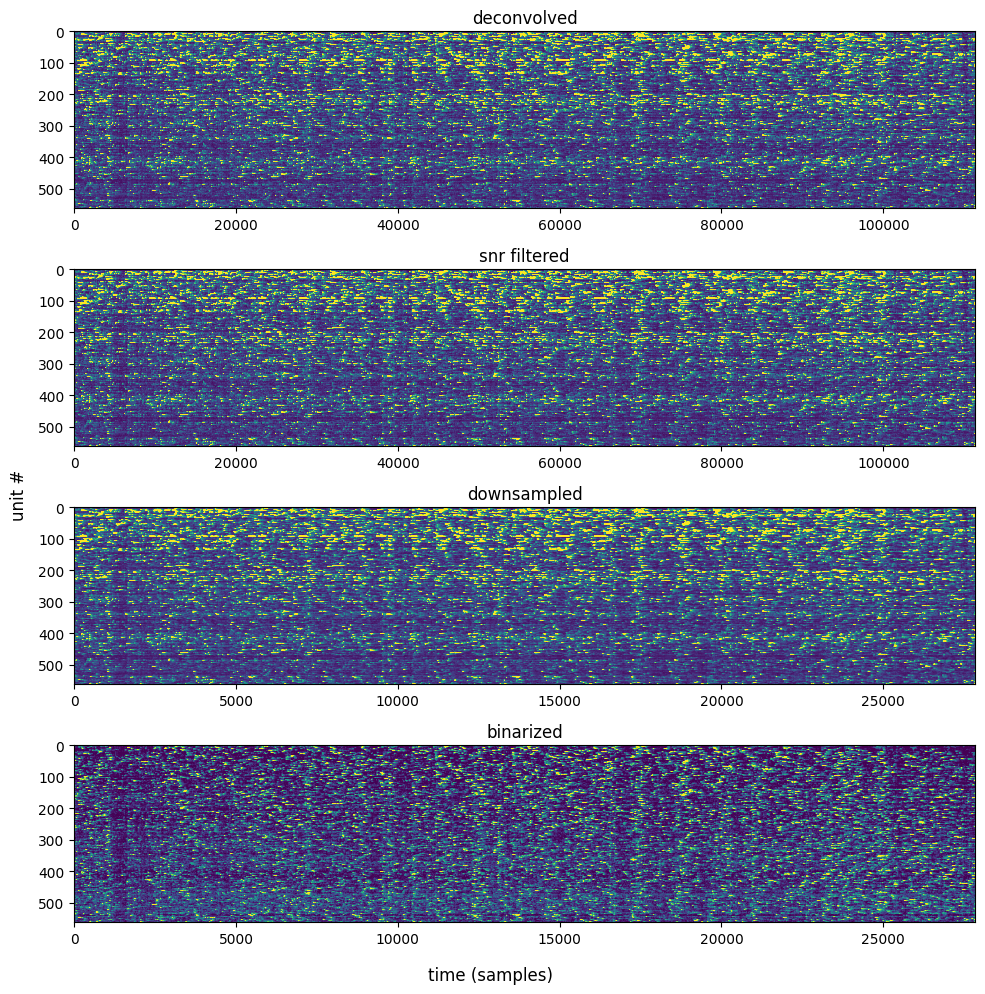

In [4]:
# visualize the preprocessing steps
fig, axes = plt.subplots(4, 1, figsize=(10, 10))

axes[0].imshow(data_deconvolved, aspect='auto', vmin=0, vmax=1)
axes[0].set(title="deconvolved")
axes[1].imshow(data_snr_filtered, aspect='auto', vmin=0, vmax=1)
axes[1].set(title="snr filtered")
axes[2].imshow(downsampled_data, aspect='auto', vmin=0, vmax=1)
axes[2].set(title="downsampled")
axes[3].imshow(binarized_data, aspect='auto', vmin=0, vmax=0.25)
axes[3].set(title="binarized")
fig.supxlabel('time (samples)')
fig.supylabel('unit #')

fig.tight_layout()

# Calculate autocorrelograms of imaging data using pynapple

## Get raw autocorrelograms

In [5]:
# define the custom autocorrelogram function without zero-ing out the 0 lag correlation
def my_compute_autocorrelogram(
    group, binsize, windowsize, time_units="s", norm=True
):
    newgroup = group
    autocorrs = {}

    binsize = nap.TsIndex.format_timestamps(
        np.array([binsize], dtype=np.float64), time_units
    )[0]
    windowsize = nap.TsIndex.format_timestamps(
        np.array([windowsize], dtype=np.float64), time_units
    )[0]

    for n in newgroup.keys():
        spk_time = newgroup[n].index
        auc, times = nap.process.correlograms._cross_correlogram(spk_time, spk_time, binsize, windowsize)
        autocorrs[n] = pd.Series(index=np.round(times, 6), data=auc, dtype="float")

    autocorrs = pd.DataFrame.from_dict(autocorrs)

    # Do NOT normalize
    # DO NOT zero out the center

    return autocorrs.astype("float")

In [6]:
# get data in terms of spike times for pynapple autocorrelogram function
samprate = 30.95 / downsample_factor  # 30.95 Hz is sampling rate described in the paper
spike_times = [[i / samprate for i, val in enumerate(unit) if val == 1] for unit in binarized_data] 
tsgroup = nap.TsGroup({i: nap.Ts(unit_data) for i, unit_data in enumerate(spike_times)})
tsgroup

Index    rate
-------  -------
0        0.39312
1        0.48653
2        0.43732
3        0.38644
4        0.34307
5        0.47819
6        0.4262
...      ...
556      0.48625
557      0.5691
558      0.51517
559      0.58995
560      0.45233
561      0.5324
562      0.36587

In [7]:
# compute the autocorrelogram for each unit
binsize = 1 / samprate
acorr = my_compute_autocorrelogram(tsgroup, binsize=binsize, windowsize=560)
acorr

,0,1,2,3,4,5,6,7,8,9,...,553,554,555,556,557,558,559,560,561,562
-559.870760,0.459653,0.455407,0.167244,0.256061,0.238270,0.296904,0.131230,0.246877,0.242542,0.225999,...,0.365852,0.399129,0.451587,0.389308,0.517849,0.547012,0.459437,0.413745,0.452533,0.388051
-559.741519,0.415877,0.420036,0.182001,0.205962,0.206919,0.305901,0.141324,0.228813,0.238566,0.208157,...,0.333089,0.392127,0.516764,0.415852,0.491390,0.480201,0.415681,0.475569,0.476775,0.335135
-559.612279,0.437765,0.420036,0.206596,0.261628,0.225729,0.292406,0.131230,0.246877,0.262423,0.214105,...,0.327629,0.476154,0.428309,0.433548,0.532969,0.634700,0.477668,0.332898,0.464654,0.376292
-559.483038,0.421349,0.442143,0.182001,0.267194,0.213189,0.287907,0.156466,0.228813,0.234590,0.214105,...,0.278484,0.483156,0.507453,0.362764,0.540529,0.492728,0.484961,0.361432,0.456573,0.305737
-559.353797,0.388517,0.420036,0.172163,0.217095,0.213189,0.305901,0.156466,0.252899,0.262423,0.214105,...,0.354931,0.455147,0.456242,0.424700,0.517849,0.559539,0.488607,0.385211,0.444452,0.311617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559.353797,0.388517,0.420036,0.172163,0.217095,0.213189,0.305901,0.156466,0.252899,0.262423,0.214105,...,0.354931,0.455147,0.456242,0.424700,0.517849,0.559539,0.488607,0.385211,0.444452,0.311617
559.483038,0.421349,0.442143,0.182001,0.267194,0.213189,0.287907,0.156466,0.228813,0.234590,0.214105,...,0.278484,0.483156,0.507453,0.362764,0.540529,0.492728,0.484961,0.361432,0.456573,0.305737
559.612279,0.437765,0.420036,0.206596,0.261628,0.225729,0.292406,0.131230,0.246877,0.262423,0.214105,...,0.327629,0.476154,0.428309,0.433548,0.532969,0.634700,0.477668,0.332898,0.464654,0.376292
559.741519,0.415877,0.420036,0.182001,0.205962,0.206919,0.305901,0.141324,0.228813,0.238566,0.208157,...,0.333089,0.392127,0.516764,0.415852,0.491390,0.480201,0.415681,0.475569,0.476775,0.335135


## Normalize and sort autocorrelograms by power

In [8]:
# convert to corr coeff and z-score each autocorrelogram
acorr_zscored = acorr.copy(deep=True)
acorr_coeff = acorr.copy(deep=True)
for i in acorr:
    acorr_coeff[i].values[:] = acorr[i].values / np.max(acorr[i].values)
    acorr_zscored[i].values[:] = zscore(acorr_coeff[i].values[:])

In [9]:
# sort by power value
from scipy import signal

# calculate power value
# nperseg should be power of 2 close to the number of bins in 17.6 minutes (used by their paper)
nperseg = 8196  # 17.6*60/0.120 = 8800
Pxxs = np.zeros((len(acorr_zscored.keys()), int(nperseg/2+1)))
Fs = 1/binsize
for i, key in enumerate(acorr_zscored.keys()):
    f, Pxxs[i,:] = signal.welch(acorr_zscored[key].values, Fs, window="hamming", nperseg=nperseg)

# get sorting index
ind = np.argsort(np.max(Pxxs, axis=1))[::-1]  # largest power first
acorr_sorted = acorr_zscored.loc[:, acorr.columns[ind]]

## Plot the autocorrelograms sorted by peak power

Text(0.02, 0.5, 'Neuron no.')

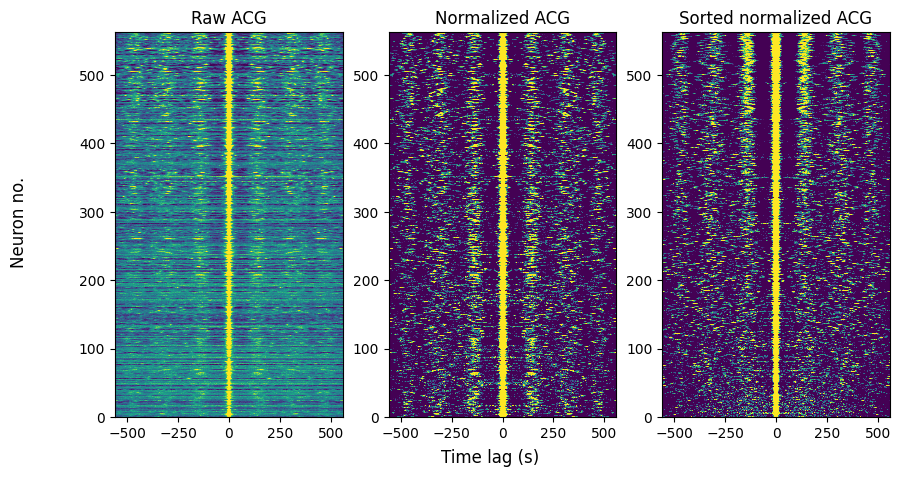

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

axes[0].imshow(acorr.values.T, extent=(-560, 560, 0, len(acorr.keys())), interpolation='none', aspect='auto', vmin=0, vmax=1)
axes[0].set(title='Raw ACG')
axes[1].imshow(acorr_zscored.values.T, extent=(-560, 560, 0, len(acorr.keys())), interpolation='none', aspect='auto', vmin=0, vmax=1)
axes[1].set(title='Normalized ACG')
axes[2].imshow(acorr_sorted.values.T, extent=(-560, 560, 0, len(acorr.keys())), interpolation='none', aspect='auto', vmin=0, vmax=1)
axes[2].set(title='Sorted normalized ACG')

fig.supxlabel('Time lag (s)')
fig.supylabel('Neuron no.')

## Plot the power spectra

[Text(0.5, 1.0, 'PSD'),
 Text(0, 0.5, 'Unit no.'),
 Text(0.5, 0, 'Frequency (Hz)')]

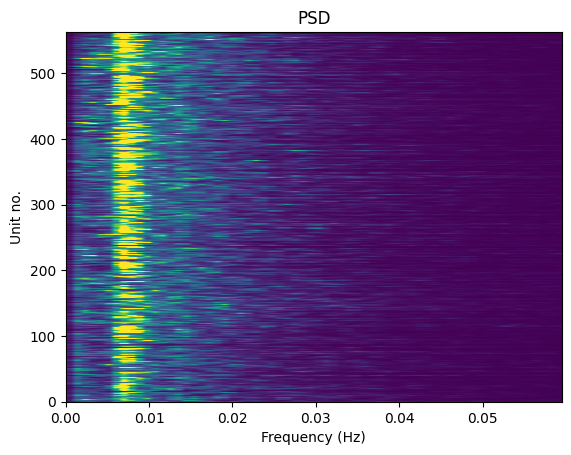

In [11]:
frequency_cutoff = 0.06
freq_bins = f[f < frequency_cutoff]

fig, axes = plt.subplots()
axes.imshow(Pxxs[:, f < frequency_cutoff], aspect='auto', extent=[f[0], freq_bins[-1], 0, np.shape(Pxxs)[0]], vmax=200)
axes.set(title='PSD', ylabel='Unit no.', xlabel='Frequency (Hz)')

## Replicate Figure 1

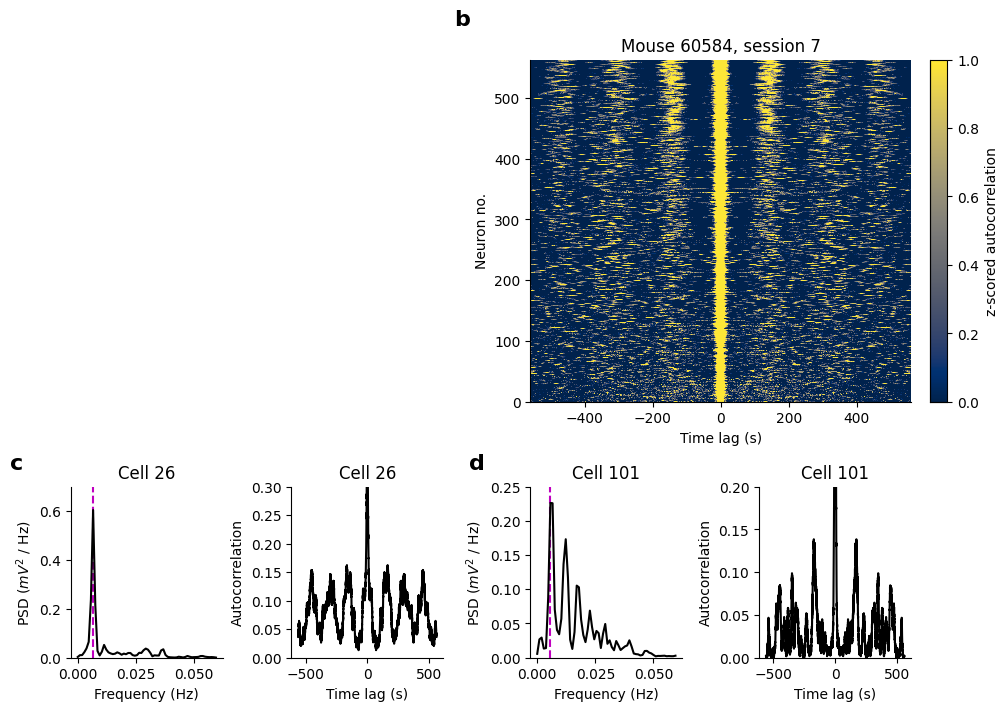

In [12]:
# plot example cell figure
example_unit_ind_a = 26
example_unit_ind_b = 101

mosaic = """
    ..AA
    ..AA
    BCDE
    """

fig = plt.figure(layout="constrained", figsize=(10, 7))
ax_dict = fig.subplot_mosaic(mosaic)

im = ax_dict['A'].imshow(acorr_sorted.values.T, extent=(-560, 560, 0, len(acorr.keys())), 
                         interpolation='none', aspect='auto', vmin=0, vmax=1, cmap='cividis')
ax_dict['A'].set(title='Mouse 60584, session 7', xlabel='Time lag (s)', ylabel='Neuron no.')
fig.colorbar(im, ax=ax_dict['A'], label='z-scored autocorrelation')
ax_dict['A'].text(-0.2, 1.1, 'b', weight='bold', fontsize=16, transform=ax_dict['A'].transAxes)

ax_dict['B'].plot(freq_bins, Pxxs[example_unit_ind_a, f < frequency_cutoff] / 1000, color='k')
ax_dict['B'].axvline(freq_bins[np.argmax(Pxxs[example_unit_ind_a, f < frequency_cutoff])], linestyle='dashed', color='m', zorder=0)
ax_dict['B'].set(title=f'Cell {example_unit_ind_a}', ylabel='PSD ($mV^2$ / Hz)', xlabel='Frequency (Hz)', ylim=[0, 0.7])
ax_dict['B'].text(-0.4, 1.1, 'c', weight='bold', fontsize=16, transform=ax_dict['B'].transAxes)

ax_dict['C'].plot(acorr_coeff[example_unit_ind_a], color='k')
ax_dict['C'].set(title=f'Cell {example_unit_ind_a}', xlabel="Time lag (s)", ylabel='Autocorrelation', ylim=[0, 0.3])

ax_dict['D'].plot(freq_bins, Pxxs[example_unit_ind_b, f < frequency_cutoff] / 1000, color='k')
ax_dict['D'].axvline(freq_bins[np.argmax(Pxxs[example_unit_ind_b, f < frequency_cutoff])], linestyle='dashed', color='m', zorder=0)
ax_dict['D'].set(title=f'Cell {example_unit_ind_b}', ylabel='PSD ($mV^2$ / Hz)', xlabel='Frequency (Hz)', ylim=[0, 0.25])
ax_dict['D'].text(-0.4, 1.1, 'd', weight='bold', fontsize=16, transform=ax_dict['D'].transAxes)

ax_dict['E'].plot(acorr_coeff[example_unit_ind_b], color='k')
ax_dict['E'].set(title=f'Cell {example_unit_ind_b}', xlabel="Time lag (s)", ylabel='Autocorrelation', ylim=[0, 0.2])

sns.despine()

In [13]:
# source data for cell 26 from their extended data fig 3 example plots
their_psd = [
    2.164140045, 0.936799855, 0.014777785, 0.025616386, 0.051207745, 
    0.103470668, 0.348857779, 0.874535173, 0.272484269, 0.022395072, 
    0.006984114, 0.041230129, 0.110603252, 0.063186911, 0.038691347, 
    0.024032934, 0.017232328, 0.02135088, 0.043774849, 0.045572166, 
    0.021639647, 0.02099261, 0.020641403, 0.046147864, 0.047608178, 
    0.026401972, 0.02047379, 0.019297138, 0.037776221, 0.03951575, 
    0.070552916, 0.108795917, 0.09445725, 0.046595646, 0.014198104, 
    0.022644655, 0.019074954, 0.022334899, 0.108225714, 0.124250824, 
    0.038952846, 0.013760564, 0.006278491, 0.006456599, 0.006416975, 
    0.008110193, 0.022403608, 0.01605689, 0.003531902, 0.005144315, 
    0.022867031, 0.015742252, 0.006999519, 0.013432602, 0.010497339, 
    0.007426481, 0.01699561, 0.019904547, 0.011615554, 0.008788691, 
    0.006706023, 0.00638913, 0.005440857, 0.004028371, 0.002810639
]